In [1]:
# 5. FGSM
# FGSM(Fast Gradient Signed Method)
# 적대적 샘플 생성
# 신경망을 혼란시킬 목적으로 만들어진 특수한 입력

In [2]:
#미리 훈련된 모형 불러오기
import tensorflow as tf
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True,
weights='imagenet')
pretrained_model.trainable = False
decode_predictions =tf.keras.applications.mobilenet_v2.decode_predictions

14536120/14536120 [==============================] - 1s 0us/step


In [3]:
# 이미지 전처리 함수
def preprocess(image):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, (224, 224))
    image =tf.keras.applications.mobilenet_v2.preprocess_input(image)
    image = image[None, ...]
    return image
# 레이블 출력 함수
def get_imagenet_label(probs):
    return decode_predictions(probs, top=1)[0][0]

In [4]:
###############################
#샘플 이미지
image_raw = tf.io.read_file('c:/data/dog.jpg')
image = tf.image.decode_image(image_raw)
image = preprocess(image)
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 1s 799ms/step


35363/35363 [==============================] - 0s 1us/step
0.41818488


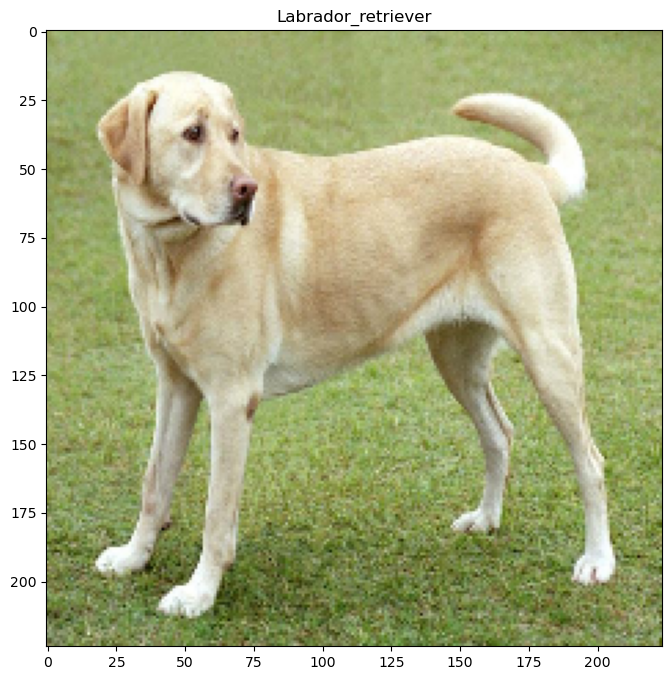

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (8, 8)
mpl.rcParams['axes.grid'] = False
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5) # To change [-1, 1] to [0,1]
_, image_class, class_confidence =get_imagenet_label(image_probs)
print(class_confidence)
plt.title(f'{image_class}')
plt.show()

In [7]:
#적대적 이미지 생성
#입력 이미지에 대한 gradient를 사용하여 원본 이미지에 가하게될 왜곡 생성
loss_object = tf.keras.losses.CategoricalCrossentropy()
def create_adversarial_pattern(input_image, input_label):
    with tf.GradientTape() as tape:
        tape.watch(input_image)
        prediction = pretrained_model(input_image)
        loss = loss_object(input_label, prediction)
# 원본과의 손실 계산
    gradient = tape.gradient(loss, input_image)
    signed_grad = tf.sign(gradient)
    return signed_grad

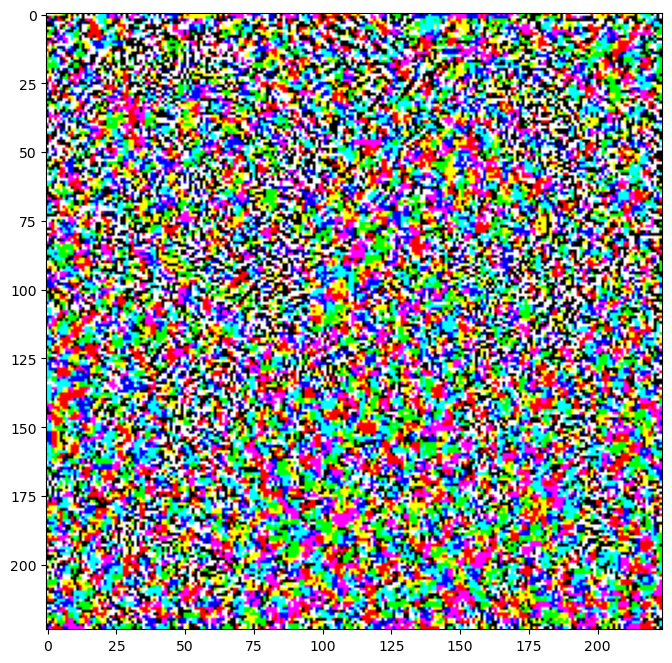

In [8]:
labrador_retriever_index = 208
label = tf.one_hot(labrador_retriever_index,
image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))
# 왜곡된 이미지
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5); # To change [-1, 1] to [0,1]

In [10]:
def display_images(image, description):
    _, label, confidence =get_imagenet_label(pretrained_model.predict(image))
    plt.figure()
    plt.imshow(image[0]*0.5+0.5)
    plt.title(f'{description} \n {label} : {confidence*100:.2f}%Confidence')
    plt.show()

1/1 [==============================] - 0s 30ms/step


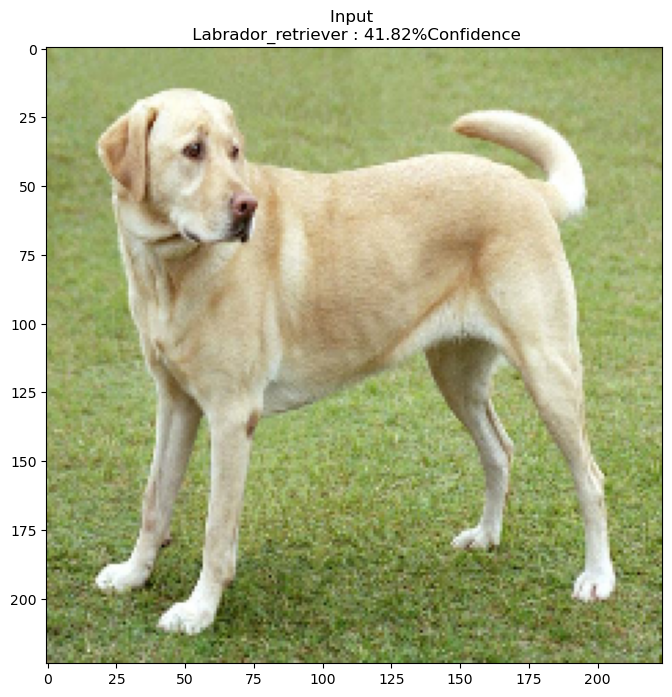

1/1 [==============================] - 0s 45ms/step


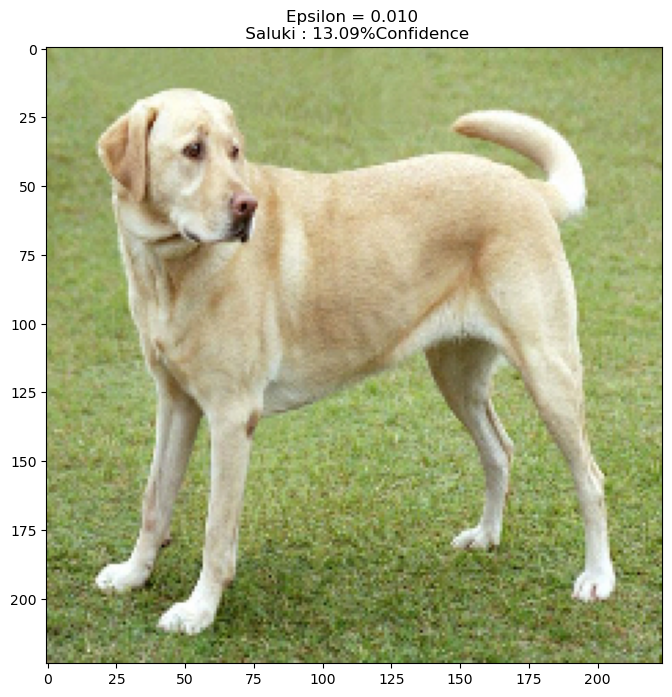

1/1 [==============================] - 0s 42ms/step


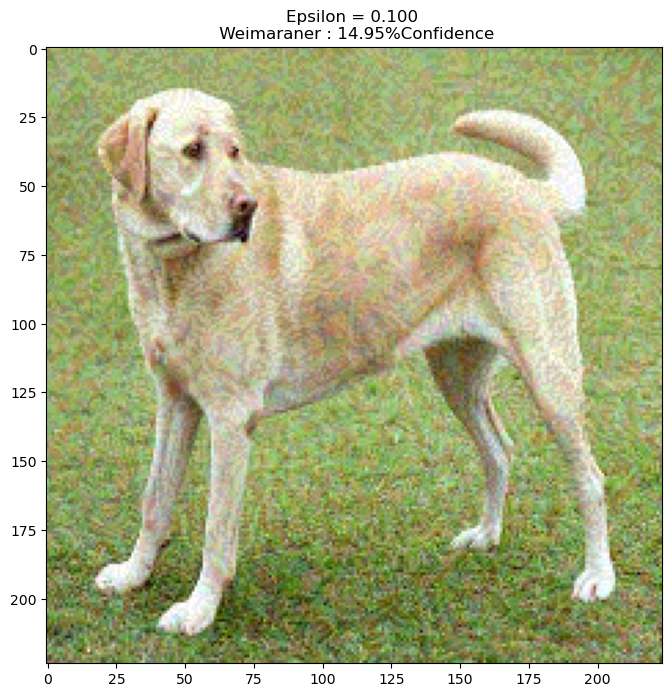

1/1 [==============================] - 0s 48ms/step


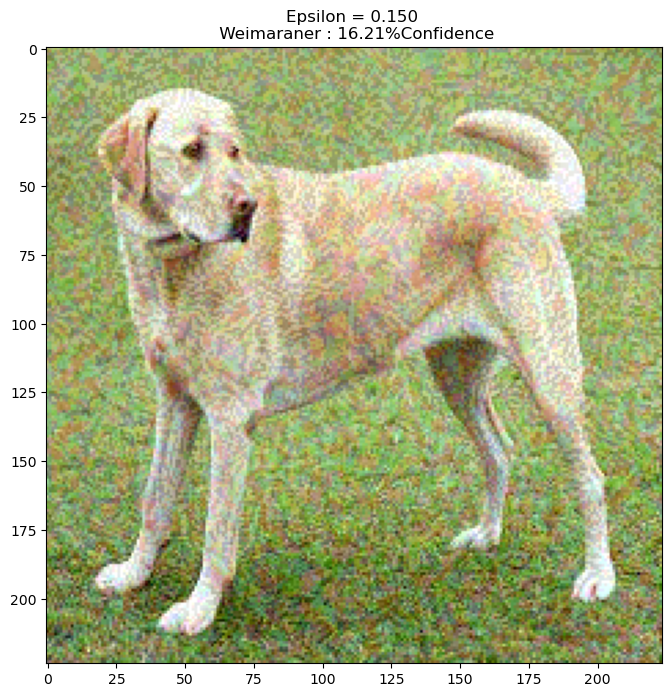

In [11]:
#왜곡된 이미지로 인해 이미지 분류 오류 발생
epsilons = [0, 0.01, 0.1, 0.15] # 값이 커질수록 이미지 왜곡이심해짐
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else
'Input') for eps in epsilons]
for i, eps in enumerate(epsilons):
    adv_x = image + eps*perturbations
    adv_x = tf.clip_by_value(adv_x, -1, 1)
    display_images(adv_x, descriptions[i])